# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

## Задание 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 



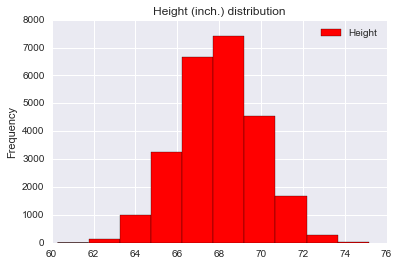

In [3]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')

In [4]:
data.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


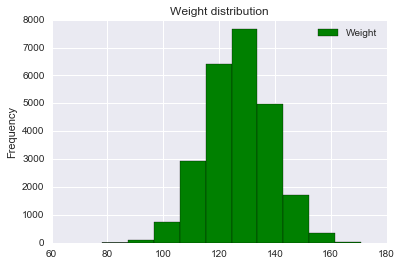

In [7]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Weight distribution')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). 

In [8]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [9]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)
data.head()

,Height,Weight,BMI
Index,,,
1,65.78331,112.9925,18.357573
2,71.51521,136.4873,18.762577
3,69.39874,153.0269,22.338895
4,68.21660,142.3354,21.504526
5,67.78781,144.2971,22.077581


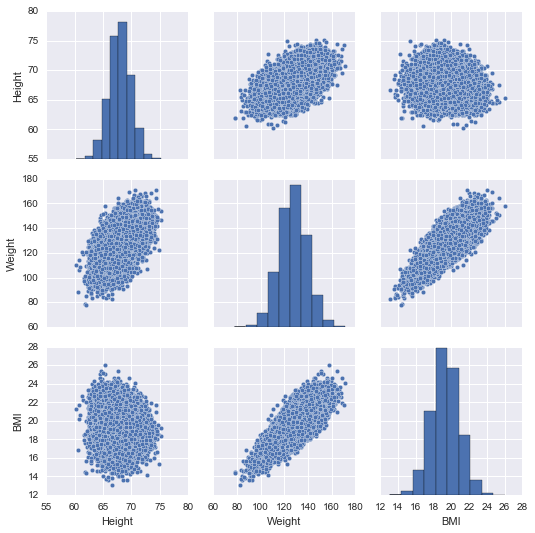

In [10]:
sns.pairplot(data)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

 Создадим в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Построим «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. 

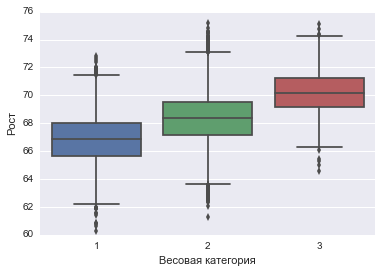

In [11]:
def weight_category(weight):
    pass
    if weight<120:
        res=1
    elif weight>=150:
        res=3
    else:
        res=2
    return res

data['weight_cat'] = data['Weight'].apply(weight_category)
plot= sns.boxplot(x="weight_cat", y="Height", data=data)
plot.set_xlabel(u'Весовая категория')
plot.set_ylabel(u'Рост')

 Построим scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. 

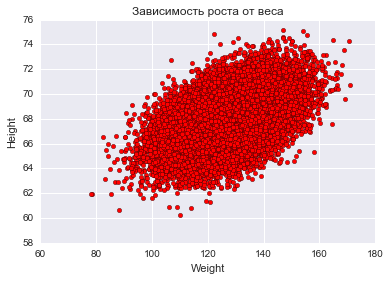

In [12]:
data.plot(x="Weight", y='Height', kind='scatter', 
           color='red', title=u"Зависимость роста от веса")

## Задание 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

Напишем функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [13]:
def error(w0,w1):
    S=0
    for i in range(1,data.shape[0]+1):
        S+=(data.Height[i]-(w0 + w1*data.Weight[i]))**2
    return S

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

Проведем на графике зависимости роса от веса две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. 

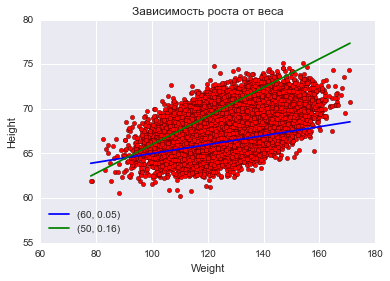

In [14]:
data.plot(x="Weight", y='Height', kind='scatter', 
           color='red', title=u"Зависимость роста от веса")

def graph(w0,w1,c):
    x1=np.linspace(min(data.Weight), max(data.Weight), 100, endpoint=True)
    y1=w0+w1*x1
    return plt.plot(x1,y1,c, label=(w0,w1))

graph(60,0.05,"b")
graph(50,0.16, "g")
plt.legend(loc='lower left')

plt.show()

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.Построим график зависимости функции ошибки от параметра $w_1$ при $w_0$ = 50. 

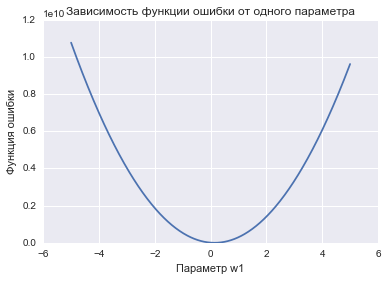

In [15]:
w1=np.linspace(-5,5,500)
plt.plot(w1, error(50,w1))
plt.xlabel(u"Параметр w1")
plt.ylabel(u"Функция ошибки")
plt.title(u"Зависимость функции ошибки от одного параметра")
plt.show()

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

С помощью метода *minimize_scalar* из *scipy.optimize* найдём минимум функции для значений параметра  $w_1$ в диапазоне [-5,5]. Проведём на графике зависимости веса от роста прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное оптимальное значение параметра $w_1$. 

In [16]:
f2=lambda w1:error(50,w1)
res = opt.minimize_scalar(f2,bounds=(-5,5))
w1_opt=res.x

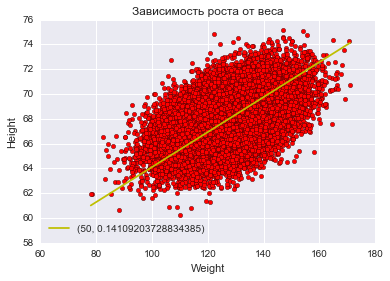

In [17]:
data.plot(x="Weight", y='Height', kind='scatter', 
           color='red', title=u"Зависимость роста от веса")
graph(50,w1_opt, "y")
plt.legend(loc='lower left')
plt.show()

In [18]:
from mpl_toolkits.mplot3d import Axes3D

 Построим 3D-график зависимости функции ошибки от параметров $w_0$ и $w_1$. 

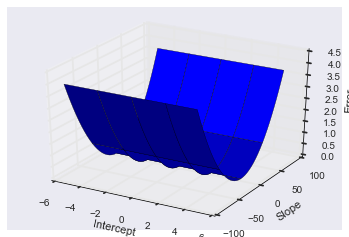

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
             
X1 = np.arange(-5, 5, 0.25)
Y1 = np.arange(-100, 100, 5)
X1,Y1 = np.meshgrid(X1, Y1)
Z1=error(X1,Y1)
surf = ax.plot_surface(X1,Y1, Z1)
ax.set_xlabel("Intercept")
ax.set_ylabel("Slope")
ax.set_zlabel('Error')
plt.show()

 С помощью метода *minimize* из scipy.optimize найдем минимум функции для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0).  Проведем на графике из зависимрсти веса от роста прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. 

In [20]:
def error2(x):
   return error(*x)

In [21]:
res= opt.minimize(error2, (0,0),  method='L-BFGS-B', bounds= ((-100,100), (-5,5)))
w0_min=res.x[0]
w1_min=res.x[1]

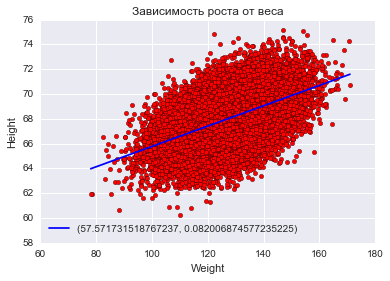

In [23]:
data.plot(x="Weight", y='Height', kind='scatter', 
           color='red', title=u"Зависимость роста от веса")
graph(w0_min,w1_min, "b")
plt.legend(loc='lower left')
plt.show()